# The real

This notebook is to serve as a full compareson of model using better feature extraction.  We will extract surnames, an interaction between age and fare, and the total family size and run  the set of features on different models and compare the difference.  We will compare decision trees and Adaboost with decision tree stumps since they performed better in our pocs.

In [3]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import sys
module_path = os.path.abspath(os.path.join('../data/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import features
import util

ImportError: No module named 'features'

In [2]:
train_raw = pd.read_csv('../data/train.csv', header=0)
test_raw = pd.read_csv('../data/test.csv', header=0)
test_labels = test_raw['PassengerId']

Confirm that the test set does not have any missing data we have to deal with.

In [3]:
len(test_raw) - test_raw.count()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [4]:
data_raw = pd.concat([train_raw, test_raw])

# Feature engineering

We will create a surname feature and a family size feature and then run it all through the preprocessing script. After will will add an interaction term between fare and age.  This need to happen after the script due to missing values.

In [5]:
data_raw['Fam_size'] = data_raw['SibSp'] + data_raw['Parch'] + 1

In [6]:
data_raw['Name'].str.extract('(,\s)(.*\.)', expand=False)[1].value_counts()

Mr.                          757
Miss.                        260
Mrs.                         196
Master.                       61
Dr.                            8
Rev.                           8
Col.                           4
Ms.                            2
Mlle.                          2
Major.                         2
Don.                           1
Dona.                          1
the Countess.                  1
Mrs. Martin (Elizabeth L.      1
Sir.                           1
Lady.                          1
Mme.                           1
Jonkheer.                      1
Capt.                          1
Name: 1, dtype: int64

In [7]:
titles = ['Mr.', 'Miss.', 'Mrs.', 'Master.']
data_raw['Surname'] = data_raw['Name'].str.extract('(,\s)(.*\.)', expand=False)[1]
data_raw.loc[~data_raw['Surname'].isin(titles),'Surname'] = 'Rare'

In [9]:
categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Fam_size', 'Surname']
numerical_features = ['Age', 'Fare']
target = 'Survived'
data_clean = features.decision_tree_preprocessing(data_raw, 
                                                  target,
                                                  categorical_features=categorical_features, 
                                                  numerical_features=numerical_features, 
                                                  drop_na_columns=['Embarked'])

In [10]:
data_clean['AgeXFare'] = data_clean['Age'] * data_clean['Fare']

In [11]:
test = data_clean[pd.isnull(data_clean['Survived'])]
train = data_clean[~pd.isnull(data_clean['Survived'])]

y = train[target]

del test[target]
del train[target]

X = train

# Visualizations

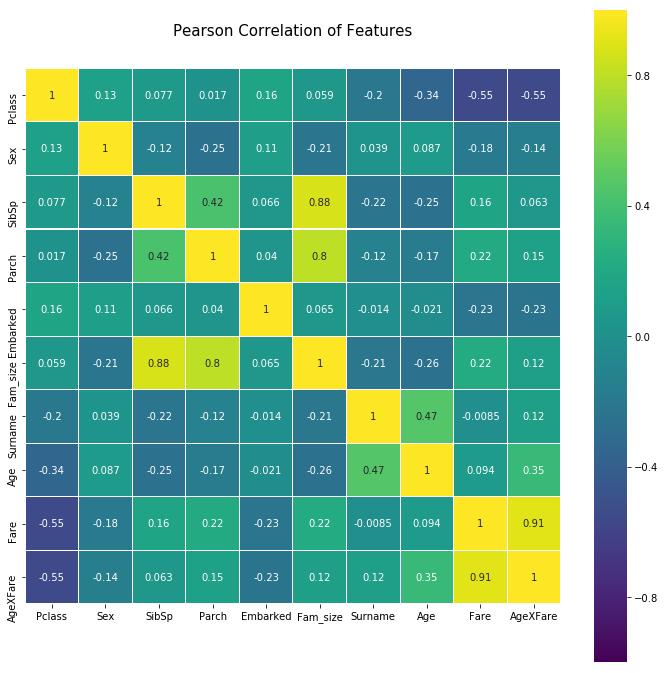

In [28]:
cmp = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, vmin=-1.0, square=True, cmap=cmp, 
            linecolor='white', annot=True)

# Building the models

In [12]:
model_ada = ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1))
model_tree = tree.DecisionTreeClassifier()

In [13]:
scores_ada = cross_val_score(model_ada, X, y, cv=100)
scores_tree = cross_val_score(model_tree, X, y, cv=100)

In [14]:
print("AdaBoost accuracy: %0.8f (+/- %0.2f)" % (scores_ada.mean(), scores_ada.std() * 2))
print("Decision tree accuracy: %0.8f (+/- %0.2f)" % (scores_tree.mean(), scores_tree.std() * 2))

AdaBoost accuracy: 0.81575000 (+/- 0.27)
Decision tree accuracy: 0.77000000 (+/- 0.26)


# Prediction

In [15]:
model_ada.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [16]:
prediction = model_ada.predict(test)
model_ada.score(X, y)

0.85264341957255341

In [17]:
#util.save_submission(prediction, test_labels)